# Cross-matching entre catalogues X et optique

"Entraînement" au cross-matching avec les catalogues erosita et sdss_wen → envoyé par Reza dans un mail du 14/02/2025 à 12h26

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import math
import scipy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import Planck13

In [16]:
from gem_astmatch_modified import match_celestial_objects_list_deg,match_celestial_objects,create_skycoord_from_fits,do_celest_match_fits   

# Import catalogues

Fonction pour passer de .fit à un dataframe (REMARQUE : Le programme ne semble pas fonctionner pour certains fits binary → dans le doute télécharger des fits ascii) : 

In [17]:
#Description des tables :
# catass -  est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen 
# dtass - contient juste l'information d'association, pour l'objet la plus proche (en angle) 
# dtassall - contient l'information d'association , uniquement pour les objets X ayant été associés à un objet optique, et tous les objets qui passent le critère d'association (angulaire et en redshift) 

'''
#Ne fonctionnait car le cgicher étaut un fits binary
def fits_to_dataframe_catass(fits_file):
    with fits.open(fits_file) as hdul:
        catass = hdul[1].data 
        catass_df = pd.DataFrame(catass)

        dtass_binary = hdul[2].data 
        dtass = Table(dtass_binary) 
        dtass.write('dtass.fits', overwrite=True, format='ascii') 
        dtass_df = pd.DataFrame(dtass)

        dtassall = hdul[3].data 
        dtassall_df = pd.DataFrame(dtassall)
    return catass_df, dtass_df, dtassall_df'''

# Transforme certaines extensions d'un fichier FITS en un fichier FITS ASCII
def fits_binary_to_fits_ascii_list(fits_file, liste_indexes, name_list):  # liste_indexes indique les extensions du fits à lire ; name_list correspond aux noms des fichiers de sortie
    for x, x_name in zip(liste_indexes, name_list):  # Use zip to iterate over both lists simultaneously
        with fits.open(fits_file) as hdul:
            data = hdul[x].data
            data_table = Table(data)  # Convertit le tableau binaire en un tableau astropy
            data_table.write(x_name, overwrite=True, format='ascii')  # Écrit le tableau dans un fichier FITS ASCII

#Transforme un FITS ascii en un DataFrame pandas
def ascii_to_dataframe(ascii_file, delimiter=' '):
    data_df = pd.read_csv(ascii_file, delimiter=delimiter)
    return data_df

# Transfome la première extension d'un fichier FITS en un DataFrame pandas
def fits_to_dataframe(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data 
        data_df = pd.DataFrame(data)
    return data_df



# Transforme certaines extensions d'un fichier FITS en un DataFrame pandas(→ pour que ça fonctionne, il faut un fits ascii et pas un fits binaire)
def fits_to_dataframe_list(fits_file, liste_indexes):  # liste_indexes indique les extensions du fits à lire
    df_list = []  # Initialize the list outside the loop
    with fits.open(fits_file) as hdul:
        for x in liste_indexes:
            data = hdul[x].data  # Select the data in the xth extension
            df_list.append(pd.DataFrame(data))
            print(df_list)
    return df_list  # Return the entire list of DataFrames

#def fits_binary_to_fits_ascii(fits_file):

On précise le chemin menant à chacun des catalogues pour ensuite les importer

In [18]:
path_X = 'clxC.fits' #la première table est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen
name_X = 'eROSITA_BULBUL_2024'

path_opt = '../DESI_eRass/DESI_Legacy_Wen_2024.fit'
name_opt = 'Wen_2024_DESI_Legacy'

In [19]:
'''clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!
fits_binary_to_fits_ascii_list(path_X,[1,2,3],['clxC_catass.ascii','clxC_dtass.ascii','clxC_dtassall.ascii']) #Change les fichiers dans le dossier !''' 

"clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!\nfits_binary_to_fits_ascii_list(path_X,[1,2,3],['clxC_catass.ascii','clxC_dtass.ascii','clxC_dtassall.ascii']) #Change les fichiers dans le dossier !"

In [20]:
if path_X == 'clxB.fits':
    clx_catass_df = ascii_to_dataframe('clxB_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxB_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxB_dtassall.ascii')  

elif path_X == 'clxC.fits':
    clx_catass_df = ascii_to_dataframe('clxC_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxC_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxC_dtassall.ascii')

In [21]:
# On veut récupérer la table Erosita de départ que Reza a utilisé → Ezra Bulbul 2024
columns_to_exclude = ['idm', 'asscnt','idass','dstass','delz','maxassdist','zph','rmag','r200','N200']
table_X = clx_catass_df.drop(columns=columns_to_exclude) # Pour l'instant, table eRosita
table_X


,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,pcont,...,CTS300kpc,CTS500,F500,L500,KT,Mgas500,YX500,M500,Fgas500,R500
0,0.021730,-38.624903,1eRASS J000005.2-383729,0.021730,-38.624903,94.800003,0.3153,0.0079,photo_z,0.006,...,33.4,48.2,47.110,140.172,1.90,279.160004,553.19,36.070000,0.075,971
1,0.089191,-82.831715,1eRASS J000021.4-824954,0.089191,-82.831715,184.199997,0.0891,0.0002,cg_spec_z,0.000,...,128.8,189.5,98.355,24.747,NaN,111.919998,0.00,16.990000,0.065,819
2,0.129422,-50.151013,1eRASS J000031.0-500903,0.129422,-50.151013,117.300003,0.0681,0.0002,cg_spec_z,0.218,...,29.9,30.3,23.991,2.862,1.79,1.920000,9.34,3.630000,0.009,493
3,0.132712,-63.025286,1eRASS J000031.8-630131,0.132712,-63.025286,139.600006,0.2448,0.0058,photo_z,0.005,...,24.3,49.6,33.228,57.877,NaN,171.949997,0.00,22.040001,0.076,846
4,0.189080,-46.394874,1eRASS J000045.3-462341,0.189080,-46.394874,109.500000,0.0925,0.0004,cg_spec_z,0.715,...,20.0,20.8,16.818,3.996,0.96,6.400000,11.17,3.780000,0.019,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12241,359.741833,-60.612333,1eRASS J235858.0-603644,359.741833,-60.612333,142.500000,0.1052,0.0064,photo_z,0.000,...,204.7,506.8,337.065,97.721,NaN,358.950012,0.00,38.669998,0.093,1071
12242,359.799123,-55.296727,1eRASS J235911.7-551748,359.799123,-55.296727,130.800003,0.2137,0.0063,photo_z,0.506,...,15.3,15.8,11.402,15.028,NaN,5.590000,0.00,8.150000,0.008,614
12243,359.864701,-34.306012,1eRASS J235927.5-341821,359.864701,-34.306012,87.500000,0.1138,0.0004,spec_z_boot,0.003,...,42.6,62.5,62.778,22.350,NaN,81.230003,0.00,14.110000,0.054,763
12244,359.980381,-44.205215,1eRASS J235955.2-441218,359.980381,-44.205215,98.099998,0.5797,0.0117,photo_z,0.982,...,12.3,13.4,12.342,165.113,NaN,41.310001,0.00,25.920000,0.020,785


REMARQUE : M500 dans la table_X est en $10^{13} M_{SUN}$.

In [22]:
table_optique = fits_to_dataframe(path_opt)
table_optique

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
0,0.00046,-37.47628,1,,J000000.1-372835,0.00046,-37.47628,0.1364,0,15.377,...,11.49,0.766,25.79,1.17,14,0.0,0.0,1,WHY18,1
1,0.00135,-56.58835,2,WH-,J000000.3-563518,0.00135,-56.58835,0.1957,0,15.712,...,11.70,0.625,23.24,1.06,7,0.0,0.0,1,,2
2,0.00172,-39.32369,3,,J000000.4-391925,0.00172,-39.32369,0.3580,0,17.713,...,11.41,0.526,15.90,0.73,7,0.0,0.0,1,Y21,3
3,0.00201,2.31980,4,,J000000.5+021911,0.00201,2.31980,0.4282,1,18.043,...,11.55,0.612,23.40,1.07,13,0.0,0.0,1,redMaPPer,4
4,0.00260,-59.01297,5,WH-,J000000.6-590047,0.00260,-59.01297,0.1380,0,14.993,...,11.69,0.606,15.71,0.73,7,0.0,0.0,1,,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581174,359.99667,4.99211,1581175,WH-,J235959.2+045932,359.99667,4.99211,0.5948,0,19.184,...,11.37,0.420,10.99,0.51,6,0.0,0.0,2,,1581175
1581175,359.99680,21.78514,1581176,,J235959.2+214707,359.99680,21.78514,0.4050,1,17.259,...,11.78,0.658,31.73,1.43,9,0.0,0.0,2,WHL,1581176
1581176,359.99817,10.04951,1581177,,J235959.6+100258,359.99817,10.04951,0.7919,0,18.904,...,11.88,0.621,33.23,1.50,8,0.0,0.0,2,CFSFDP,1581177
1581177,359.99847,-6.34469,1581178,WH-,J235959.6-062041,359.99847,-6.34469,1.0333,0,20.952,...,11.18,0.439,13.12,0.61,6,0.0,0.0,2,,1581178


REMARQUE POUR DESI Legacy Imaging Surveys WEN 2024 : M500 est en $10^{14} M_{SUN}$, on convertit donc cette colonne en $10^{13} M_{SUN}$,

In [23]:
# SEULEMENT SI WEN_2024 DESI LEGACY 

M500_opt_13 = table_optique['M500']*10
table_optique['M500'] = M500_opt_13


# Tests fonctions gem_asmatch.py

Fonctions écrites et fournies par Reza dans le fichier gem_asmatch.py

In [24]:
list_coord_1 = [(1.0,1.0), (2.0,2.0), (3.0,3.0), (4.0,4.0), (5.0,5.0),(6.0,6.0), (7.0,7.0), (8.0,8.0), (9.0,9.0), (10.0,10.0)]
list_coord_2 = [(1.0,1.0), (3.0,3.0),(5.0,5.0),(7.0,7.0),(9.0,9.0)]

eps_ang = 0.1
results_1 = match_celestial_objects_list_deg(list_coord_1,list_coord_2,eps_ang)
print("results_1 : ", results_1)

results_1 :  [(np.int64(0), np.int64(0)), (np.int64(2), np.int64(1)), (np.int64(4), np.int64(2)), (np.int64(6), np.int64(3)), (np.int64(8), np.int64(4))]


In [25]:
"""test_skycoord = create_skycoord_from_fits(clx_catass_df)
print(test_skycoord)"""

'test_skycoord = create_skycoord_from_fits(clx_catass_df)\nprint(test_skycoord)'

# Applications sur les tables

## Détermination tolérance angulaire en fonction du redshift (inspiré du code SOPHYA de Reza)

In [26]:
'''tolerance_ang = 30 # tolerance in arcseconds → 30 is approximately the tolerance of eROSITA instrument (we take taht into account because the X-instrument is less precise than the optical one)
#!!! → TO DO : Faire évoluer la tolérance angulaire en foncntion de z (z ↑ => tolerance_ang ↓) : le faire par step de z : s'inspier du code de Reza (noms variables inspirés de )
delta_z = 0.15 # Seuil de différence de redshift (idem que dans le code de Reza → choix arbitraire ?)
'''

"tolerance_ang = 30 # tolerance in arcseconds → 30 is approximately the tolerance of eROSITA instrument (we take taht into account because the X-instrument is less precise than the optical one)\n#!!! → TO DO : Faire évoluer la tolérance angulaire en foncntion de z (z ↑ => tolerance_ang ↓) : le faire par step de z : s'inspier du code de Reza (noms variables inspirés de )\ndelta_z = 0.15 # Seuil de différence de redshift (idem que dans le code de Reza → choix arbitraire ?)\n"

In [27]:
max_tol_ang_arcmin = 15.0 # tolérance angulaire plafond en arcminutes (choix ?)
min_tol_ang_arcmin = 5.0 # tolerance angulaire plancher en arcminutes (choix ?)
rayon_cluster_MPC = 1 # rayon du cluster (en MPC) → influence le calcule de la tolérance angulaire en fonction du redshift
delta_z = 0.15 # "largeur" du palier de redshift
cosmo = Planck13 # modèle cosmo utilisé

In [28]:
cosmo.luminosity_distance(0.15)

<Quantity 735.93156516 Mpc>

In [29]:
def find_tol_ang_xrt_z(cosmo,z,rayon_cluster_MPC,min_tol_ang_arcmin,max_tol_ang_arcmin):
    tol_ang_variable = rayon_cluster_MPC/cosmo.luminosity_distance(z).value # cosmo.luminosity_distance est en MPC donc tol_ang_variable est en radian
    tol_ang = math.radians((min_tol_ang_arcmin/60)) + tol_ang_variable   # Sûr ???
    if tol_ang > max_tol_ang_arcmin:
        tol_ang = math.radians(max_tol_ang_arcmin/60)
    return tol_ang 

In [30]:
find_tol_ang_xrt_z(cosmo,0.3,rayon_cluster_MPC,min_tol_ang_arcmin,max_tol_ang_arcmin) # 0.3 est un exemple de redshift (à changer) → renvoie la tolérance angulaire en arcminutes (environ 5.0 arcminutes)

np.float64(0.0020791290513146048)

In [31]:
find_tol_ang_xrt_z(cosmo,0.2,rayon_cluster_MPC,min_tol_ang_arcmin,max_tol_ang_arcmin)

np.float64(0.002443532704614974)

In [32]:
find_tol_ang_xrt_z(cosmo,0.5,rayon_cluster_MPC,min_tol_ang_arcmin,max_tol_ang_arcmin)

np.float64(0.0017972082305043988)

## Association X → optique

In [36]:
nb_bin_z = round(table_X['zBest'].max()/delta_z,0)

In [12]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_coords_X = []
for i in range(len(table_X)):
    coord = (table_X['RAJ2000'][i],table_X['DEJ2000'][i])
    liste_coords_X.append(coord)

liste_coords_optique = []
for i in range(len(table_optique)):
    coord = (table_optique['RAJ2000'][i],table_optique['DEJ2000'][i])
    liste_coords_optique.append(coord)


In [1]:
indices_crossed_list = match_celestial_objects_list_deg(liste_coords_X,liste_coords_optique,tolerance_ang) # [indice_X, indice_optique]
# ↑ La différence de z n'est pas pris en compte ici, on va prendre en compte ce seuil après


NameError: name 'match_celestial_objects_list_deg' is not defined

In [14]:
#On identifie les objets X qui ont été associés à strictement plus de 1 objet optique
data = indices_crossed_list



# Ici, on récupère les indices pour chaque association, un indice X est donc répété autant de fois que ce cluster est associé à un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_X_crossed_repetitifs")
indices_X_crossed_repetitifs = []
indices_opt_repetitifs = []
for x in data :
    indices_X_crossed_repetitifs.append(x[0])
    indices_opt_repetitifs.append(x[1])

# Ici, on ne garde qu'une seule occurrence de chaque cluster X associé à au moins un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_X_crossed")
number_of_duplicates = 0
indices_X_crossed = set()
for float1, float2 in data:
    if float1 in indices_X_crossed:
        number_of_duplicates += 1
    else:
        indices_X_crossed.add(float1)
indices_X_crossed = sorted(indices_X_crossed)
print(f"Proportion de duplicats par rapport an nombre de galaxies en X: {round(number_of_duplicates/len(table_X) * 100,3)} %")



Proportion de duplicats par rapport an nombre de galaxies en X: 0.67 %


## table_X_crossed_3D 

(Au final, on sélectionne selon la distance angulaire et on applique un seuil de z)

Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il y aura 3 fois l'indices du cluster A dans la table "table_X_crossed_repetitifs".

In [15]:
# Il peut y avoir plusieurs occurences d'un même objet X dans cette liste
table_X_crossed_repetitifs = table_X.iloc[indices_X_crossed_repetitifs]
table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_X_crossed_repetitifs = table_X_crossed_repetitifs[['__indexes'] + [col for col in table_X_crossed_repetitifs.columns if col != '__indexes']]

C:\Users\ED282972\AppData\Local\Temp\ipykernel_17760\1858826165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs


In [16]:
table_optique

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
0,0.00046,-37.47628,1,,J000000.1-372835,0.00046,-37.47628,0.1364,0,15.377,...,11.49,0.766,25.79,11.7,14,0.0,0.0,1,WHY18,1
1,0.00135,-56.58835,2,WH-,J000000.3-563518,0.00135,-56.58835,0.1957,0,15.712,...,11.70,0.625,23.24,10.6,7,0.0,0.0,1,,2
2,0.00172,-39.32369,3,,J000000.4-391925,0.00172,-39.32369,0.3580,0,17.713,...,11.41,0.526,15.90,7.3,7,0.0,0.0,1,Y21,3
3,0.00201,2.31980,4,,J000000.5+021911,0.00201,2.31980,0.4282,1,18.043,...,11.55,0.612,23.40,10.7,13,0.0,0.0,1,redMaPPer,4
4,0.00260,-59.01297,5,WH-,J000000.6-590047,0.00260,-59.01297,0.1380,0,14.993,...,11.69,0.606,15.71,7.3,7,0.0,0.0,1,,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581174,359.99667,4.99211,1581175,WH-,J235959.2+045932,359.99667,4.99211,0.5948,0,19.184,...,11.37,0.420,10.99,5.1,6,0.0,0.0,2,,1581175
1581175,359.99680,21.78514,1581176,,J235959.2+214707,359.99680,21.78514,0.4050,1,17.259,...,11.78,0.658,31.73,14.3,9,0.0,0.0,2,WHL,1581176
1581176,359.99817,10.04951,1581177,,J235959.6+100258,359.99817,10.04951,0.7919,0,18.904,...,11.88,0.621,33.23,15.0,8,0.0,0.0,2,CFSFDP,1581177
1581177,359.99847,-6.34469,1581178,WH-,J235959.6-062041,359.99847,-6.34469,1.0333,0,20.952,...,11.18,0.439,13.12,6.1,6,0.0,0.0,2,,1581178


In [17]:
diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_X_crossed_repetitifs)):
    index_X = indices_X_crossed_repetitifs[i] ; index_opt = indices_opt_repetitifs[i]

    X_row_of_interest = table_X_crossed_repetitifs[table_X_crossed_repetitifs['__indexes'] == index_X].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(X_row_of_interest['zBest'] - table_optique['zCl'][index_opt]) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((X_row_of_interest['RAJ2000'] - table_optique['RAJ2000'][index_opt])**2 + (X_row_of_interest['DEJ2000'] - table_optique['DEJ2000'][index_opt])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_X_crossed_repetitifs['id_asso'] = indices_opt_repetitifs
table_X_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_X_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

In [18]:
table_X_crossed_repetitifs

,__indexes,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,...,L500,KT,Mgas500,YX500,M500,Fgas500,R500,id_asso,diff_z,dist_ang
0,0,0.021730,-38.624903,1eRASS J000005.2-383729,0.021730,-38.624903,94.800003,0.3153,0.0079,photo_z,...,140.172,1.90,279.160004,553.19,36.070000,0.075,971,61,0.0034,0.002795
2,2,0.129422,-50.151013,1eRASS J000031.0-500903,0.129422,-50.151013,117.300003,0.0681,0.0002,cg_spec_z,...,2.862,1.79,1.920000,9.34,3.630000,0.009,493,556,0.0206,0.007464
3,3,0.132712,-63.025286,1eRASS J000031.8-630131,0.132712,-63.025286,139.600006,0.2448,0.0058,photo_z,...,57.877,NaN,171.949997,0.00,22.040001,0.076,846,946785,0.0249,0.007631
4,4,0.189080,-46.394874,1eRASS J000045.3-462341,0.189080,-46.394874,109.500000,0.0925,0.0004,cg_spec_z,...,3.996,0.96,6.400000,11.17,3.780000,0.019,495,732,0.0117,0.002941
7,7,0.267457,-43.333211,1eRASS J000104.1-431959,0.267457,-43.333211,99.800003,0.0381,0.0011,spec_z_boot,...,NaN,NaN,NaN,NaN,NaN,NaN,-2147483648,1060,0.0007,0.006105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12233,12233,359.253644,-34.758361,1eRASS J235700.8-344530,359.253644,-34.758361,90.400002,0.0493,0.0005,spec_z_boot,...,143.698,3.66,345.600006,1255.14,46.869999,0.074,1163,943802,0.0001,0.001064
12234,12234,359.287281,-74.700654,1eRASS J235708.9-744202,359.287281,-74.700654,157.500000,0.3709,0.0138,photo_z,...,71.767,NaN,113.160004,0.00,18.150000,0.062,756,943895,0.0401,0.006836
12237,12237,359.359244,-79.659768,1eRASS J235726.2-793935,359.359244,-79.659768,177.000000,0.1421,0.0043,photo_z,...,110.842,NaN,387.809998,0.00,41.270000,0.094,1081,944117,0.0043,0.008961
12239,12239,359.703174,-61.431914,1eRASS J235848.7-612554,359.703174,-61.431914,143.800003,0.3862,0.0109,photo_z,...,87.552,NaN,105.370003,0.00,21.820000,0.050,800,945337,0.0033,0.003092


Tout l'intéret de récupérer ce dataframe "table_X_crossed_repetitifs" est de pouvoir lui appliquer un seuil pour "diff_z" : en effet, l'association faite avec la fonction 'match_celestial_objects_list_deg' ne se basait que sur la distance angulaire entre les clusters. En appliquant ce seuil sur le redshift, on passe d'un cross-matching "2D" à "3D".

In [19]:
# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift

table_X_crossed_3D = table_X_crossed_repetitifs[table_X_crossed_repetitifs['diff_z'] < delta_z]
print(np.round(100-(len(table_X_crossed_3D)/len(table_X_crossed_repetitifs))*100,1), " % des associations sont éliminées par le critère de redshift") 

table_optique_associated_3D = table_optique.loc[table_X_crossed_3D['id_asso']]

3.9  % des associations sont éliminées par le critère de redshift


## table_X_crossed
Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice du cluster A dans la table "table_X_crossed" (pas de seuil sur la différence de z, association uniquement '2D').

In [20]:
#Pour chaque objet X, on va identifier le nombre d'objets optiques associés, aisni que les indices de ces objets optiques

associations_dict_X = {}
for x in indices_X_crossed:
    associations_dict_X[x] = []
    for float1, float2 in indices_crossed_list:
        if float1 == x:
            associations_dict_X[x].append(float2)

#Maintenant, on va ajouter à chaque objet X le nombre d'objets optiques associés
for x in indices_X_crossed:
    num_associations = len(associations_dict_X[x])
    associations_dict_X[x] = (associations_dict_X[x], num_associations)

#On obtient un dictionnaire de la forme {indice_X : (indices_objets_optique, nombre_objets_optique_associés)}
print("Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) : ",'\n' )
associations_dict_X
            

Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) :  



{np.int64(0): ([np.int64(61)], 1),
 np.int64(2): ([np.int64(556)], 1),
 np.int64(3): ([np.int64(946785)], 1),
 np.int64(4): ([np.int64(732)], 1),
 np.int64(7): ([np.int64(1060)], 1),
 np.int64(8): ([np.int64(1106)], 1),
 np.int64(11): ([np.int64(1177)], 1),
 np.int64(13): ([np.int64(1653)], 1),
 np.int64(14): ([np.int64(1889)], 1),
 np.int64(18): ([np.int64(2091)], 1),
 np.int64(27): ([np.int64(3857)], 1),
 np.int64(30): ([np.int64(4300)], 1),
 np.int64(32): ([np.int64(4468)], 1),
 np.int64(33): ([np.int64(4617)], 1),
 np.int64(39): ([np.int64(949537)], 1),
 np.int64(41): ([np.int64(5970)], 1),
 np.int64(42): ([np.int64(6008)], 1),
 np.int64(43): ([np.int64(6148)], 1),
 np.int64(44): ([np.int64(6209)], 1),
 np.int64(47): ([np.int64(6941)], 1),
 np.int64(50): ([np.int64(7119)], 1),
 np.int64(52): ([np.int64(7510)], 1),
 np.int64(53): ([np.int64(7900)], 1),
 np.int64(57): ([np.int64(8389)], 1),
 np.int64(61): ([np.int64(9022)], 1),
 np.int64(62): ([np.int64(9520)], 1),
 np.int64(64): ([n

In [21]:
# On compare le nombres d'associations que j'obtiens avec celles dans clx_catass_df

# Moi
print(f"Nombres d'éléments associés dans les catalogues, avec une tolérance de {tolerance_ang} arcsecondes :",len(indices_crossed_list))
print('\n')

# clx_catass_df (Reza)
clx_catass_df_crossed = clx_catass_df[clx_catass_df['asscnt'] != 0]
print("A titre de comparaison, voici le nombre de clusters X qui ont au moins un cross-match en optique (dans le code par Reza)  :",len(clx_catass_df_crossed))

Nombres d'éléments associés dans les catalogues, avec une tolérance de 30 arcsecondes : 5156


A titre de comparaison, voici le nombre de clusters X qui ont au moins un cross-match en optique (dans le code par Reza)  : 1726


Maintenant, on récupère dans la table X les objets qui ont une association :

In [22]:
table_X_crossed = table_X.iloc[indices_X_crossed] #; table_X_crossed = table_X_crossed.reset_index(drop=True) # On reset l'index pour ne pas avoir de mismacth dans les calculs par la suite
#table_optique_crossed = table_optique.iloc[indices_optique_crossed] ; table_optique_crossed = table_optique_crossed.reset_index(drop=True)

In [23]:
#On calcule les informations d'associations "diff_z" et "dist_ang" pour chaque objet X

diff_z_list = [] # Liste qui va contenir les différences de redshift entre l'objet X et l'ensemble des objets optiques associés
dist_ang_list = [] # Liste qui va contenir les distances angulaires entre l'objet X et l'ensemble des objets optiques associés
for index, x in table_X_crossed.iterrows():
    obj_opt_ass = associations_dict_X[index][0] #liste des objets optiques associés à l'objet X courant
    diff_z = []
    dist_ang = []
    for j in range(len(obj_opt_ass)): # On parcourt la liste des objets optiques associés à l'objet X
        diff_z.append(abs(table_X_crossed['zBest'][index] - table_optique['zCl'][obj_opt_ass[j]]))
        dist_ang.append(np.sqrt((table_X_crossed['RAJ2000'][index] - table_optique['RAJ2000'][obj_opt_ass[j]])**2 + (table_X_crossed['DEJ2000'][index] - table_optique['DEJ2000'][obj_opt_ass[j]])**2)) 
    diff_z_list.append(diff_z) # On ajoute la liste des différences de redshift à la liste diff_z_list
    dist_ang_list.append(dist_ang)
    #print(f"Index: {index}, Element: {x}")
    #print(associations_dict_X[i])
    # print(associations_dict_X[index])
    #print(associations_dict_X[index][0][j])
    """diff_z.append(abs(table_X_crossed['zBest'][i] - table_optique['Z'][associations_dict_X[i][0]]))
    diff_z_list.append(diff_z)"""

In [24]:
# On ajoute les informations d'associations à table_X_crossed. En comparaison de ce qu'a fait Reza on a : Nb_assos <-> idm ; id_assos <-> idass ; diff_z <-> delz ; dist_ang <-> dstass  

#Nb_assos :
nb_assos_list = [x[1][1] for x in associations_dict_X.items()]
table_X_crossed['nb_assos'] = nb_assos_list

#id_assos :
id_assos_list = [x[1][0] for x in associations_dict_X.items()]
table_X_crossed['id_assos'] = id_assos_list

#diff_z
table_X_crossed['diff_z'] = diff_z_list

#dist_ang
table_X_crossed['dist_ang'] = dist_ang_list


C:\Users\ED282972\AppData\Local\Temp\ipykernel_17760\1718203622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed['nb_assos'] = nb_assos_list
C:\Users\ED282972\AppData\Local\Temp\ipykernel_17760\1718203622.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed['id_assos'] = id_assos_list
C:\Users\ED282972\AppData\Local\Temp\ipykernel_17760\1718203622.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [25]:
table_X_crossed

,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,pcont,...,KT,Mgas500,YX500,M500,Fgas500,R500,nb_assos,id_assos,diff_z,dist_ang
0,0.021730,-38.624903,1eRASS J000005.2-383729,0.021730,-38.624903,94.800003,0.3153,0.0079,photo_z,0.006,...,1.90,279.160004,553.19,36.070000,0.075,971,1,[61],[0.003399987792968684],[0.0027952225038013205]
2,0.129422,-50.151013,1eRASS J000031.0-500903,0.129422,-50.151013,117.300003,0.0681,0.0002,cg_spec_z,0.218,...,1.79,1.920000,9.34,3.630000,0.009,493,1,[556],[0.020600002062320807],[0.0074643166184968236]
3,0.132712,-63.025286,1eRASS J000031.8-630131,0.132712,-63.025286,139.600006,0.2448,0.0058,photo_z,0.005,...,NaN,171.949997,0.00,22.040001,0.076,846,1,[946785],[0.024899998617172292],[0.007630909214883893]
4,0.189080,-46.394874,1eRASS J000045.3-462341,0.189080,-46.394874,109.500000,0.0925,0.0004,cg_spec_z,0.715,...,0.96,6.400000,11.17,3.780000,0.019,495,1,[732],[0.011699998807907105],[0.0029406834724008284]
7,0.267457,-43.333211,1eRASS J000104.1-431959,0.267457,-43.333211,99.800003,0.0381,0.0011,spec_z_boot,0.272,...,NaN,NaN,NaN,NaN,NaN,-2147483648,1,[1060],[0.0006999995291234046],[0.006104829155290309]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12233,359.253644,-34.758361,1eRASS J235700.8-344530,359.253644,-34.758361,90.400002,0.0493,0.0005,spec_z_boot,0.000,...,3.66,345.600006,1255.14,46.869999,0.074,1163,1,[943802],[9.999992847450206e-05],[0.0010640397337269188]
12234,359.287281,-74.700654,1eRASS J235708.9-744202,359.287281,-74.700654,157.500000,0.3709,0.0138,photo_z,0.043,...,NaN,113.160004,0.00,18.150000,0.062,756,1,[943895],[0.040099994897842384],[0.006835570867973492]
12237,359.359244,-79.659768,1eRASS J235726.2-793935,359.359244,-79.659768,177.000000,0.1421,0.0043,photo_z,0.000,...,NaN,387.809998,0.00,41.270000,0.094,1081,1,[944117],[0.004299993658065798],[0.00896127962532043]
12239,359.703174,-61.431914,1eRASS J235848.7-612554,359.703174,-61.431914,143.800003,0.3862,0.0109,photo_z,0.024,...,NaN,105.370003,0.00,21.820000,0.050,800,1,[945337],[0.0032999892234802375],[0.003092057568398102]


In [26]:
# On crée la table "optique associée" en ne conservant que les objets optiques associés à un objet X

'flattened_list = [item for sublist in nested_list for item in sublist]'
id_assos_list_flatten = [id_assos for sublist in id_assos_list for id_assos in sublist] # On 'flatten' id_assos_list
table_optique_associated = table_optique.loc[id_assos_list_flatten]

In [27]:
table_optique_associated

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
61,0.02381,-38.62677,62,,J000005.7-383736,0.02381,-38.62677,0.3119,0,16.677,...,11.76,0.753,38.08,17.1,35,0.39,0.04,1,Y21,62
556,0.13626,-50.14802,557,,J000032.7-500853,0.13626,-50.14802,0.0887,0,14.056,...,11.57,0.564,14.80,6.8,8,0.00,0.00,1,WaZP,557
946785,0.12541,-63.02307,946786,,J000030.1-630123,0.12541,-63.02307,0.2697,0,15.970,...,11.93,0.990,77.76,34.2,32,-0.14,0.05,2,WHY18,946786
732,0.18620,-46.39547,733,,J000044.7-462344,0.18620,-46.39547,0.1042,0,13.998,...,11.84,0.777,30.92,14.0,13,0.00,0.00,1,CFSFDP,733
1060,0.26207,-43.33034,1061,WH-,J000102.9-431949,0.26207,-43.33034,0.0388,1,11.999,...,11.57,0.570,13.78,6.4,7,0.00,0.00,1,,1061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943802,359.25299,-34.75920,943803,,J235700.7-344533,359.25299,-34.75920,0.0494,1,11.806,...,11.81,0.905,41.58,18.6,35,0.40,0.04,1,WHY18,943803
943895,359.28067,-74.70239,943896,WH-,J235707.4-744209,359.28067,-74.70239,0.4110,0,17.277,...,11.81,0.581,21.54,9.8,12,0.00,0.00,1,,943896
944117,359.35135,-79.66401,944118,,J235724.3-793950,359.35135,-79.66401,0.1464,0,14.865,...,11.84,1.235,124.76,54.1,93,-0.56,0.12,1,WHY18,944118
945337,359.70029,-61.43303,945338,,J235848.1-612559,359.70029,-61.43303,0.3895,0,16.783,...,12.05,0.965,78.41,34.5,41,0.44,0.05,1,Y21,945338


## Association optique → X (To do)

# Visualisation résultats associations 
(sans sélection de zone l'entièreté des catalogues est pris en compte)

## Histogramme diff_z

On trace les histogrammes des différences de z entre associations (pour l'instant seulement pour les assos X→optiques), pout mon code et celui de Reza.

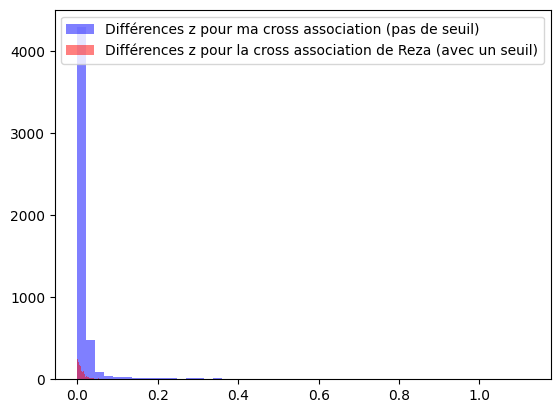

In [28]:
diff_z_list_flatten = [item for sublist in diff_z_list for item in sublist] # On 'flatten' id_assos_list
plt.hist(diff_z_list_flatten,bins=50,label='Différences z pour ma cross association (pas de seuil)',color='blue',alpha=0.5)
plt.hist(np.abs(clx_catass_df_crossed['delz']),bins=50,label='Différences z pour la cross association de Reza (avec un seuil)',color='red',alpha=0.5)
plt.legend()

# Pourquoi il n'y a qu'un seul delz pour un objet avec plusieurs associations optiques dans clx_catass_df → seule diff_z la plus faible est prise en compte dans catass (mais il y a don d'autres diff_z 'valides'<0.15
# qui sont ignorés)


On remarque avec l'histogramme précédent que certaines de mes associations différent en z de plus de 0.15 (critère chosi par Reza dans clcxmatch.cc → ass_dz0): ce ne sont donc pas des associations valides → en fait c'est parce que pour l'instant je n'ai fait qu'un cross-match 2D


## Projection "eliptique"

In [29]:
# Coordonnées galactiques objets X associés
raj2000_x_crossed_list = table_X_crossed['RAJ2000'].tolist()
dej2000_x_crossed_list = table_X_crossed['DEJ2000'].tolist()
j2000_coords_x_crossed = SkyCoord(raj2000_x_crossed_list, dej2000_x_crossed_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_x_crossed = j2000_coords_x_crossed.galactic # conversion J2000 -> galactique

# Coordonnées galactiques objets optiques associées
raj2000_opt_crossed_list = table_optique_associated['RAJ2000'].tolist()
dej2000_opt_crossed_list = table_optique_associated['DEJ2000'].tolist()
j2000_coords_opt_crossed = SkyCoord(raj2000_opt_crossed_list, dej2000_opt_crossed_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_opt_crossed = j2000_coords_opt_crossed.galactic # conversion J2000 -> galactique

# Coordonnées galactiques objets X 
raj2000_x_list = table_X['RAJ2000'].tolist()
dej2000_x_list = table_X['DEJ2000'].tolist()
j2000_coords_x = SkyCoord(raj2000_x_list, dej2000_x_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_x = j2000_coords_x.galactic # conversion J2000 -> galactique

# Coordonnées galactiques objets optiques 
raj2000_opt_list = table_optique['RAJ2000'].tolist()
dej2000_opt_list = table_optique['DEJ2000'].tolist()
j2000_coords_opt = SkyCoord(raj2000_opt_list, dej2000_opt_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_opt = j2000_coords_opt.galactic # conversion J2000 -> galactique

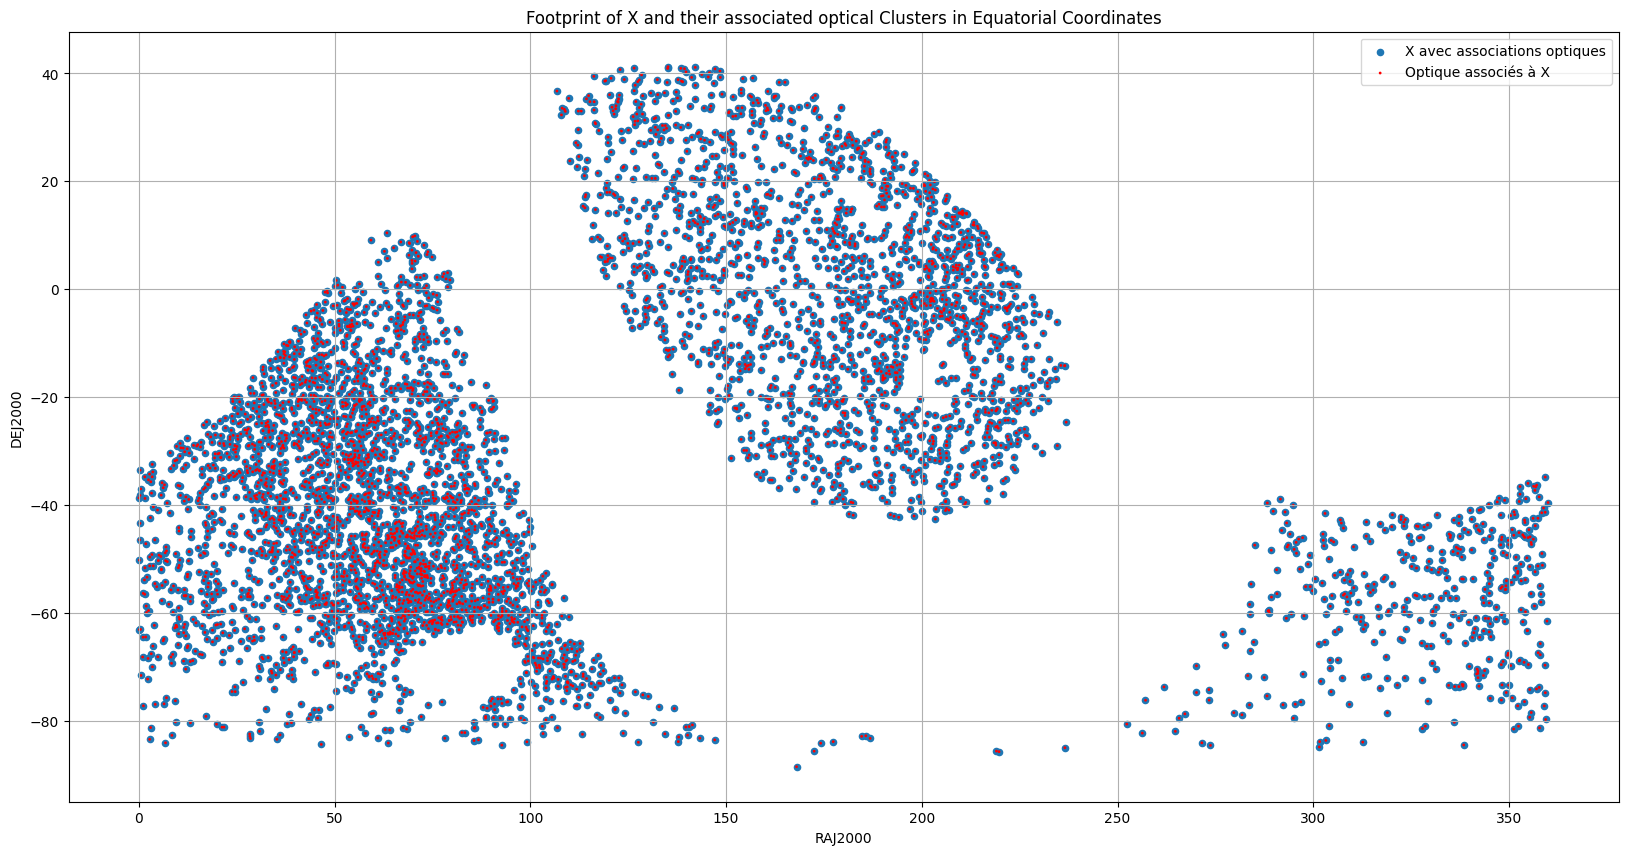

In [30]:
#→ Adapt it for SkyCoord 'galactic_coords_x_crossed' and 'galactic_coords_opt_crossed'

'''# On récupère les coordonnées galactiques des objets X
X_glon = galactic_coords_x_crossed.l.value # Longitude galactique
X_glat = galactic_coords_x_crossed.b.value # Latitude galactique

# On récupère les coordonnées galactiques des objets optiques associés
opt_glon = galactic_coords_opt_crossed.l.value # Longitude galactique
opt_glat = galactic_coords_opt_crossed.b.value # Latitude galactique

# On convertit les coordonnées galactiques en radians
X_glon_radians = np.radians(X_glon) # Longitude galactique en radians
X_glat_radians = np.radians(X_glat) # Latitude galactique en radians
opt_glon_radians = np.radians(opt_glon) # Longitude galactique en radians
opt_glat_radians = np.radians(opt_glat) # Latitude galactique en radians'''


plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)

ax_projection_X.scatter(raj2000_x_crossed_list, dej2000_x_crossed_list, s=20,label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_crossed_list, dej2000_opt_crossed_list, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates")
plt.legend()


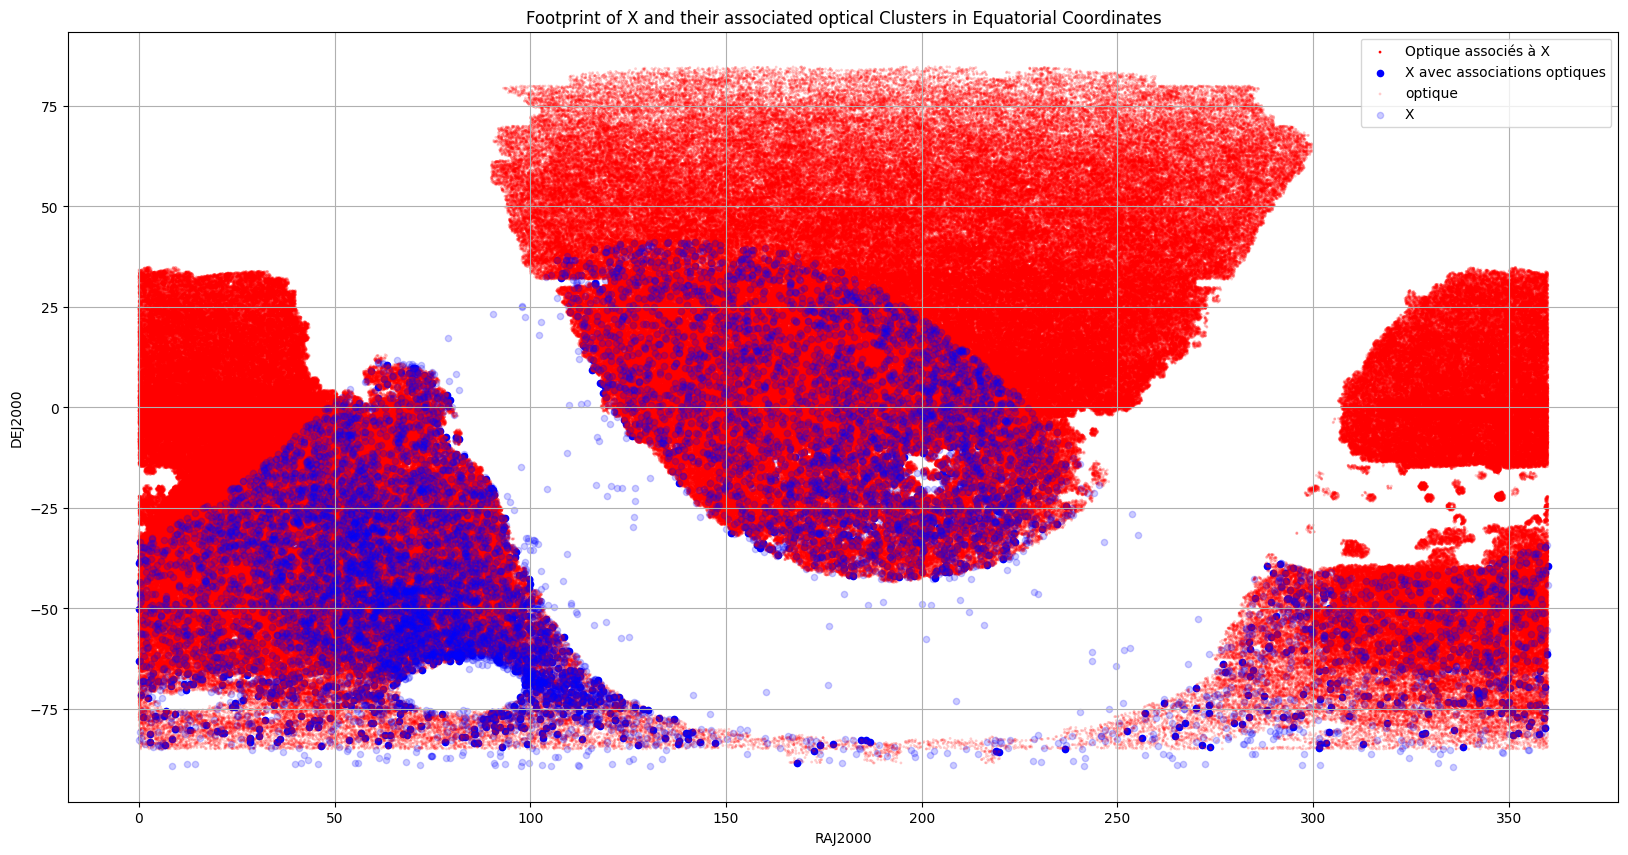

In [31]:
#On projette la footprint des associations ainsi que l'ensemble des objets X et optique


plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)
ax_projection_X_all = plt.subplot(111)
ax_projection_opt_all = plt.subplot(111)




ax_projection_opt.scatter(raj2000_opt_crossed_list, dej2000_opt_crossed_list, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

ax_projection_X.scatter(raj2000_x_crossed_list, dej2000_x_crossed_list, s=20,facecolors='blue',label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_list, dej2000_opt_list,s=1,edgecolors='red',facecolors='none',alpha=0.2,label='optique') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

ax_projection_X_all.scatter(raj2000_x_list, dej2000_x_list, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_all.grid(True)
ax_projection_X_all.set_xlabel("RAJ2000")
ax_projection_X_all.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates")
plt.legend()



# Sélection zone cross-matchs et étude spécifique

Au vu de l'affichage précédent, on observe que les footprints de eROSITA et SDSS se superposent majoritairement sur une certaine zone (110<RA<230 et -5<DE<45) dont on va donc privilégier l'étude par la suite.

In [40]:
#On sélectionne la zone d'intérêt
table_X_crossed_selected = table_X_crossed[(table_X_crossed['RAJ2000'] > 110)
                                           & (table_X_crossed['RAJ2000'] < 250)
                                           & (table_X_crossed['DEJ2000'] > -45)
                                           & (table_X_crossed['DEJ2000'] < 45)
                                           ]

table_optique_associated_selected = table_optique_associated[(table_optique_associated['RAJ2000'] > 110)
                                           & (table_optique_associated['RAJ2000'] < 250)
                                           & (table_optique_associated['DEJ2000'] > -45)
                                           & (table_optique_associated['DEJ2000'] < 45)
                                           ]

table_X_crossed_3D_selected = table_X_crossed_3D[(table_X_crossed_3D['RAJ2000'] > 110)
                                           & (table_X_crossed_3D['RAJ2000'] < 250)
                                           & (table_X_crossed_3D['DEJ2000'] > -45)
                                           & (table_X_crossed_3D['DEJ2000'] < 45)
                                           ]

table_optique_associated_3D_selected = table_optique_associated_3D[(table_optique_associated_3D['RAJ2000'] > 110)
                                           & (table_optique_associated_3D['RAJ2000'] < 250)
                                           & (table_optique_associated_3D['DEJ2000'] > -45)
                                           & (table_optique_associated_3D['DEJ2000'] < 45)
                                           ]                                                                   





In [41]:
table_optique_associated_3D

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
61,0.02381,-38.62677,62,,J000005.7-383736,0.02381,-38.62677,0.3119,0,16.677,...,11.76,0.753,38.08,17.1,35,0.39,0.04,1,Y21,62
556,0.13626,-50.14802,557,,J000032.7-500853,0.13626,-50.14802,0.0887,0,14.056,...,11.57,0.564,14.80,6.8,8,0.00,0.00,1,WaZP,557
946785,0.12541,-63.02307,946786,,J000030.1-630123,0.12541,-63.02307,0.2697,0,15.970,...,11.93,0.990,77.76,34.2,32,-0.14,0.05,2,WHY18,946786
732,0.18620,-46.39547,733,,J000044.7-462344,0.18620,-46.39547,0.1042,0,13.998,...,11.84,0.777,30.92,14.0,13,0.00,0.00,1,CFSFDP,733
1060,0.26207,-43.33034,1061,WH-,J000102.9-431949,0.26207,-43.33034,0.0388,1,11.999,...,11.57,0.570,13.78,6.4,7,0.00,0.00,1,,1061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943802,359.25299,-34.75920,943803,,J235700.7-344533,359.25299,-34.75920,0.0494,1,11.806,...,11.81,0.905,41.58,18.6,35,0.40,0.04,1,WHY18,943803
943895,359.28067,-74.70239,943896,WH-,J235707.4-744209,359.28067,-74.70239,0.4110,0,17.277,...,11.81,0.581,21.54,9.8,12,0.00,0.00,1,,943896
944117,359.35135,-79.66401,944118,,J235724.3-793950,359.35135,-79.66401,0.1464,0,14.865,...,11.84,1.235,124.76,54.1,93,-0.56,0.12,1,WHY18,944118
945337,359.70029,-61.43303,945338,,J235848.1-612559,359.70029,-61.43303,0.3895,0,16.783,...,12.05,0.965,78.41,34.5,41,0.44,0.05,1,Y21,945338


In [42]:
table_optique_associated_3D_selected

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
1112434,110.07758,23.81775,1112435,,J072018.6+234904,110.07758,23.81775,0.1696,0,14.859,...,12.00,0.952,60.15,26.7,38,0.14,0.05,2,WHY18,1112435
1115033,111.62539,27.17066,1115034,,J072630.1+271014,111.62539,27.17066,0.5810,0,18.022,...,11.87,0.765,51.64,23.0,22,0.00,0.00,2,AMF,1115034
1115600,111.95452,22.75386,1115601,,J072749.1+224514,111.95452,22.75386,0.4578,0,18.756,...,11.18,0.630,26.43,12.0,22,0.00,0.00,2,CFSFDP,1115601
1115895,112.12689,26.71109,1115896,,J072830.5+264240,112.12689,26.71109,0.1452,1,15.310,...,11.63,0.936,56.62,25.1,43,-1.02,0.12,2,WHL,1115896
423949,112.23462,29.59225,423950,,J072856.3+293532,112.23462,29.59225,0.4112,0,16.445,...,12.30,1.071,107.76,46.9,55,0.04,0.07,1,AMF,423950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771639,234.49002,-6.02164,771640,WH-,J153757.6-060118,234.49002,-6.02164,0.5128,0,17.140,...,12.20,0.988,123.34,53.5,53,0.02,0.06,1,,771640
771857,234.62193,-28.93134,771858,WH-,J153829.3-285553,234.62193,-28.93134,0.2119,0,15.549,...,11.90,0.799,39.06,17.5,24,0.00,0.00,1,,771858
773236,235.50452,-14.09183,773237,,J154201.1-140531,235.50452,-14.09183,0.2426,0,16.066,...,11.87,0.977,71.32,31.4,41,0.00,0.06,1,WHL,773237
774855,236.50478,-14.14025,774856,,J154601.1-140825,236.50478,-14.14025,0.2679,0,16.157,...,11.91,0.904,58.72,26.0,44,0.23,0.04,1,WHY18,774856


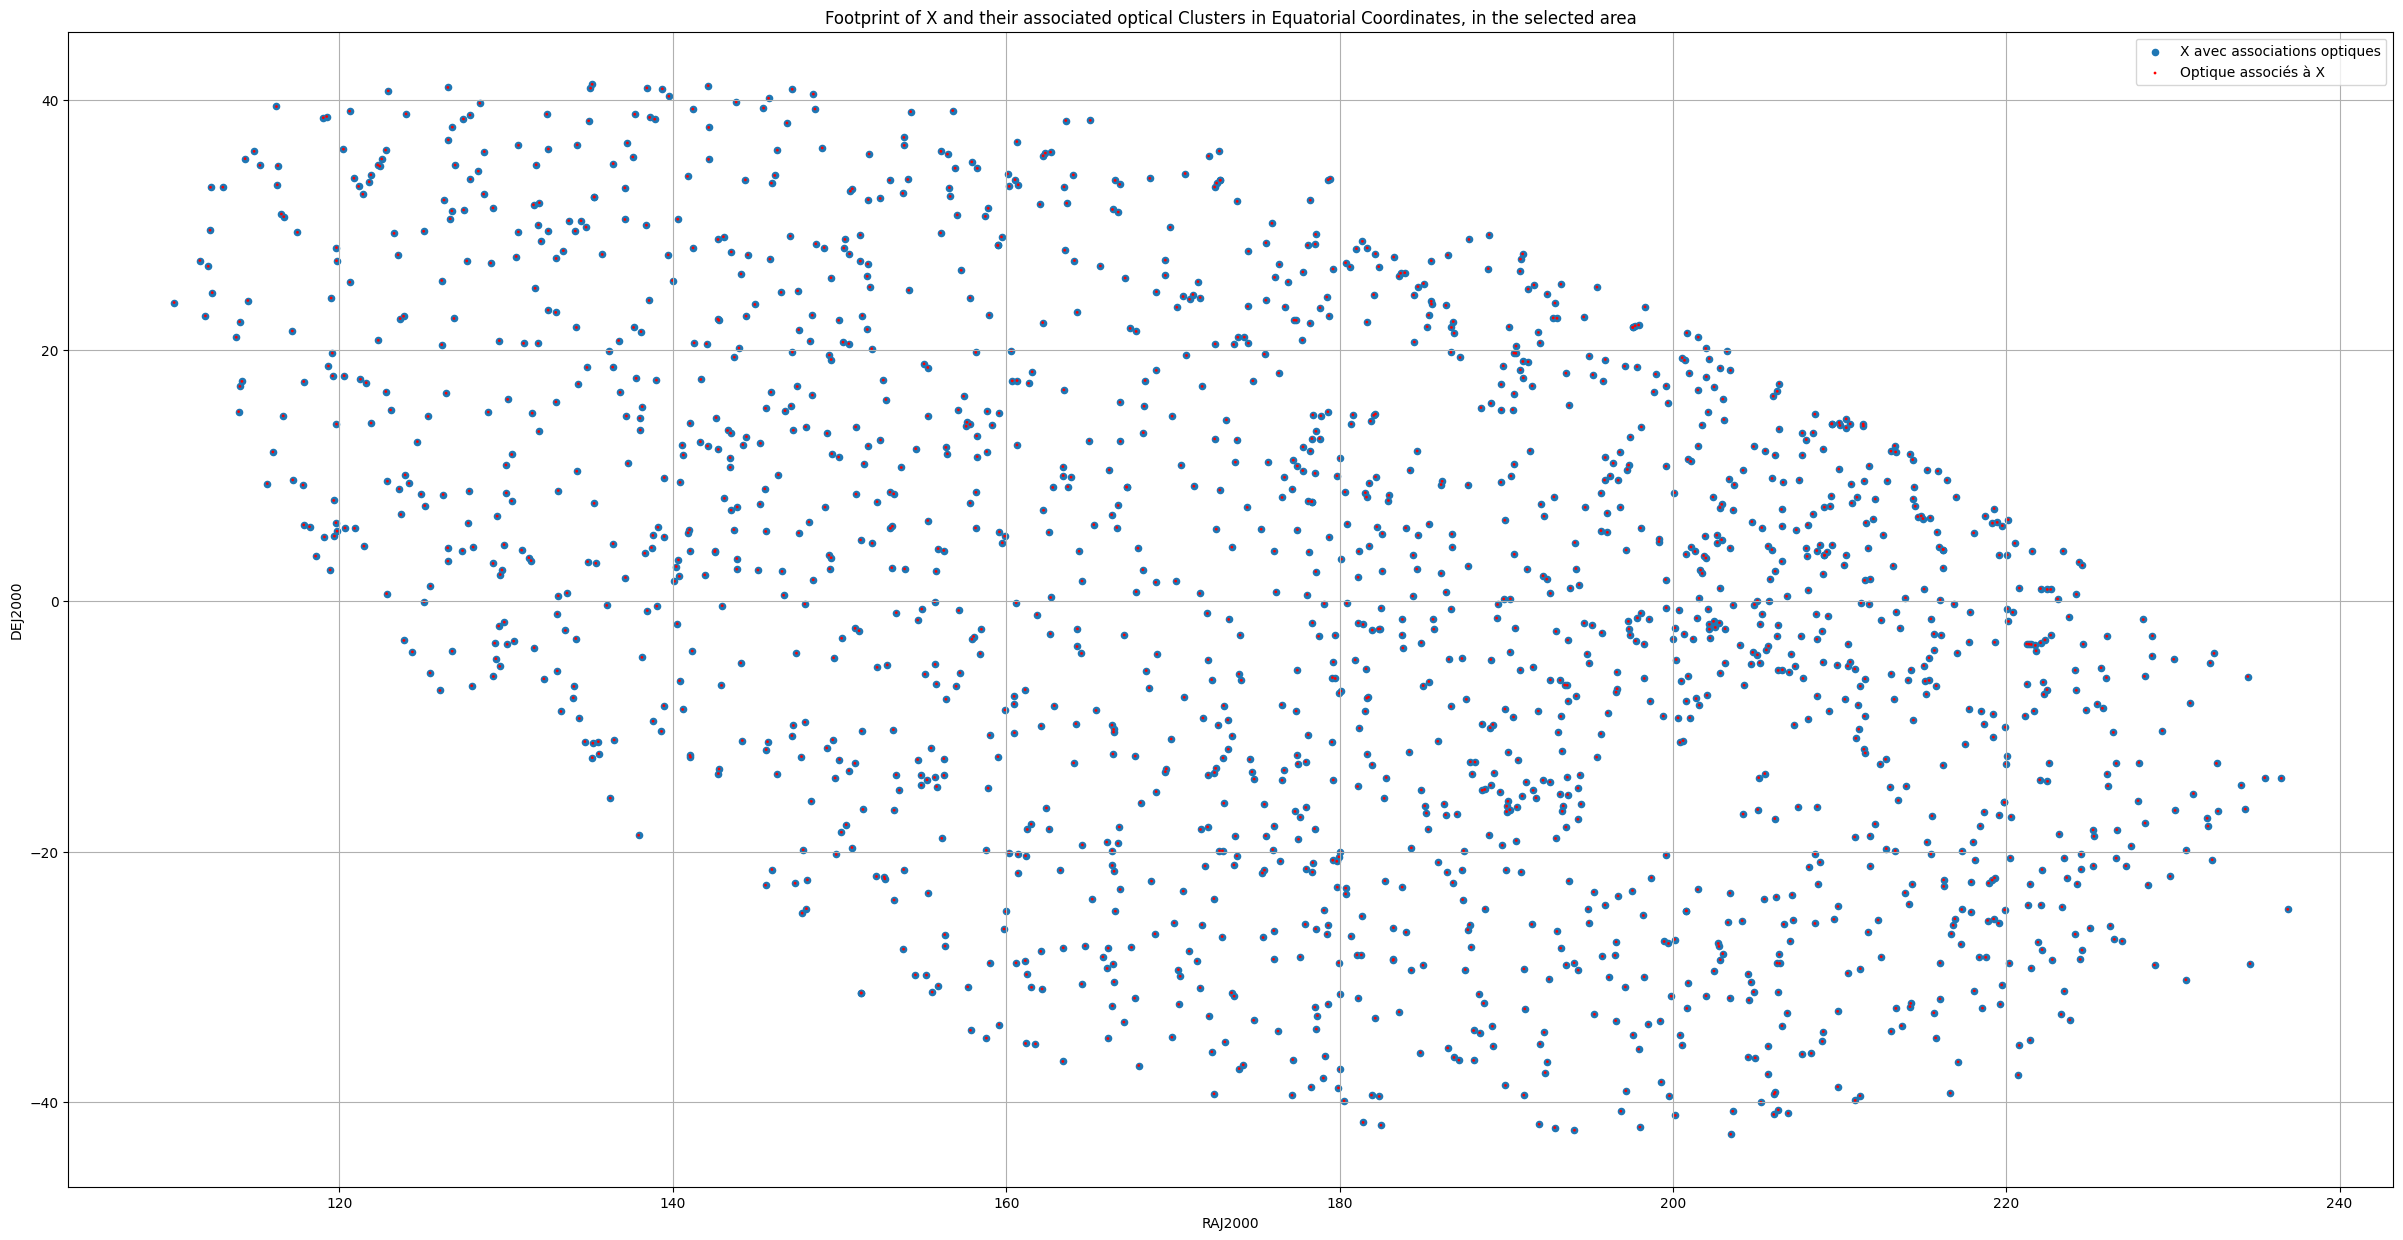

In [44]:
#On projette les footprint de la zone sélectionnée

raj2000_x_crossed_list_selected = table_X_crossed_3D_selected['RAJ2000'].tolist()
dej2000_x_crossed_list_seleceted = table_X_crossed_3D_selected['DEJ2000'].tolist()

raj2000_opt_crossed_list_selected = table_optique_associated_3D_selected['RAJ2000'].tolist()
dej2000_opt_crossed_list_seleceted = table_optique_associated_3D_selected['DEJ2000'].tolist()

plt.figure(figsize=(30, 15))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)

ax_projection_X.scatter(raj2000_x_crossed_list_selected, dej2000_x_crossed_list_seleceted, s=20,label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_crossed_list_selected, dej2000_opt_crossed_list_seleceted, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates, in the selected area")
plt.legend()


## Diagramme N-M / M-M

In [47]:
table_X_crossed_3D_selected

,__indexes,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,...,L500,KT,Mgas500,YX500,M500,Fgas500,R500,id_asso,diff_z,dist_ang
6612,6612,110.078268,23.816921,1eRASS J072018.7+234900,110.078268,23.816921,71.099998,0.1650,0.0014,spec_z_boot,...,148.820,4.14,286.679993,1321.12,47.380001,0.060,1123,1112434,0.0046,0.001077
6660,6660,111.618954,27.170115,1eRASS J072628.5+271012,111.618954,27.170115,76.500000,0.5739,0.0070,photo_z,...,499.358,0.67,556.960022,372.14,44.549999,0.122,942,1115033,0.0071,0.006459
6677,6677,111.954727,22.753730,1eRASS J072749.1+224513,111.954727,22.753730,77.599998,0.4557,0.0095,photo_z,...,136.602,NaN,188.970001,0.00,23.770000,0.071,801,1115600,0.0021,0.000244
6683,6683,112.128600,26.709046,1eRASS J072830.8+264232,112.128600,26.709046,73.800003,0.1440,0.0006,spec_z_boot,...,20.335,NaN,27.120001,0.00,10.780000,0.027,691,1115895,0.0012,0.002665
6688,6688,112.232745,29.596898,1eRASS J072855.8+293548,112.232745,29.596898,72.099998,0.4081,0.0100,photo_z,...,240.361,NaN,363.739990,0.00,38.790001,0.090,960,423949,0.0031,0.005012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11142,11142,234.486504,-6.022300,1eRASS J153756.7-060120,234.486504,-6.022300,239.500000,0.5083,0.0083,photo_z,...,189.228,1.61,324.089996,606.51,32.320000,0.099,869,771639,0.0045,0.003578
11145,11145,234.619903,-28.929993,1eRASS J153828.7-285547,234.619903,-28.929993,105.300003,0.1980,0.0056,photo_z,...,32.626,NaN,21.670000,0.00,12.480000,0.020,712,771857,0.0139,0.002434
11147,11147,235.507387,-14.094910,1eRASS J154201.7-140541,235.507387,-14.094910,105.000000,0.2376,0.0058,photo_z,...,120.602,1.28,330.339996,440.69,35.430000,0.091,993,773236,0.0050,0.004207
11153,11153,236.504913,-14.139076,1eRASS J154601.1-140820,236.504913,-14.139076,106.900002,0.2557,0.0063,photo_z,...,291.476,NaN,472.989990,0.00,67.949997,0.069,1226,774855,0.0122,0.001182


In [48]:
table_optique_associated_3D_selected

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
1112434,110.07758,23.81775,1112435,,J072018.6+234904,110.07758,23.81775,0.1696,0,14.859,...,12.00,0.952,60.15,26.7,38,0.14,0.05,2,WHY18,1112435
1115033,111.62539,27.17066,1115034,,J072630.1+271014,111.62539,27.17066,0.5810,0,18.022,...,11.87,0.765,51.64,23.0,22,0.00,0.00,2,AMF,1115034
1115600,111.95452,22.75386,1115601,,J072749.1+224514,111.95452,22.75386,0.4578,0,18.756,...,11.18,0.630,26.43,12.0,22,0.00,0.00,2,CFSFDP,1115601
1115895,112.12689,26.71109,1115896,,J072830.5+264240,112.12689,26.71109,0.1452,1,15.310,...,11.63,0.936,56.62,25.1,43,-1.02,0.12,2,WHL,1115896
423949,112.23462,29.59225,423950,,J072856.3+293532,112.23462,29.59225,0.4112,0,16.445,...,12.30,1.071,107.76,46.9,55,0.04,0.07,1,AMF,423950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771639,234.49002,-6.02164,771640,WH-,J153757.6-060118,234.49002,-6.02164,0.5128,0,17.140,...,12.20,0.988,123.34,53.5,53,0.02,0.06,1,,771640
771857,234.62193,-28.93134,771858,WH-,J153829.3-285553,234.62193,-28.93134,0.2119,0,15.549,...,11.90,0.799,39.06,17.5,24,0.00,0.00,1,,771858
773236,235.50452,-14.09183,773237,,J154201.1-140531,235.50452,-14.09183,0.2426,0,16.066,...,11.87,0.977,71.32,31.4,41,0.00,0.06,1,WHL,773237
774855,236.50478,-14.14025,774856,,J154601.1-140825,236.50478,-14.14025,0.2679,0,16.157,...,11.91,0.904,58.72,26.0,44,0.23,0.04,1,WHY18,774856


In [55]:
richness = table_optique_associated_3D_selected['lam500'] # Richness : mass proxy → define eq 2 in Wen 2024
M_500_opt = np.array(table_optique_associated_3D_selected['M500'])
M500_X = np.array(table_X_crossed_3D_selected['M500'])

In [56]:
'''richness_mass_associations = [(x, y) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]
richness_mass_associations_ = [(y, x) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]'''

"richness_mass_associations = [(x, y) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]\nrichness_mass_associations_ = [(y, x) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]"

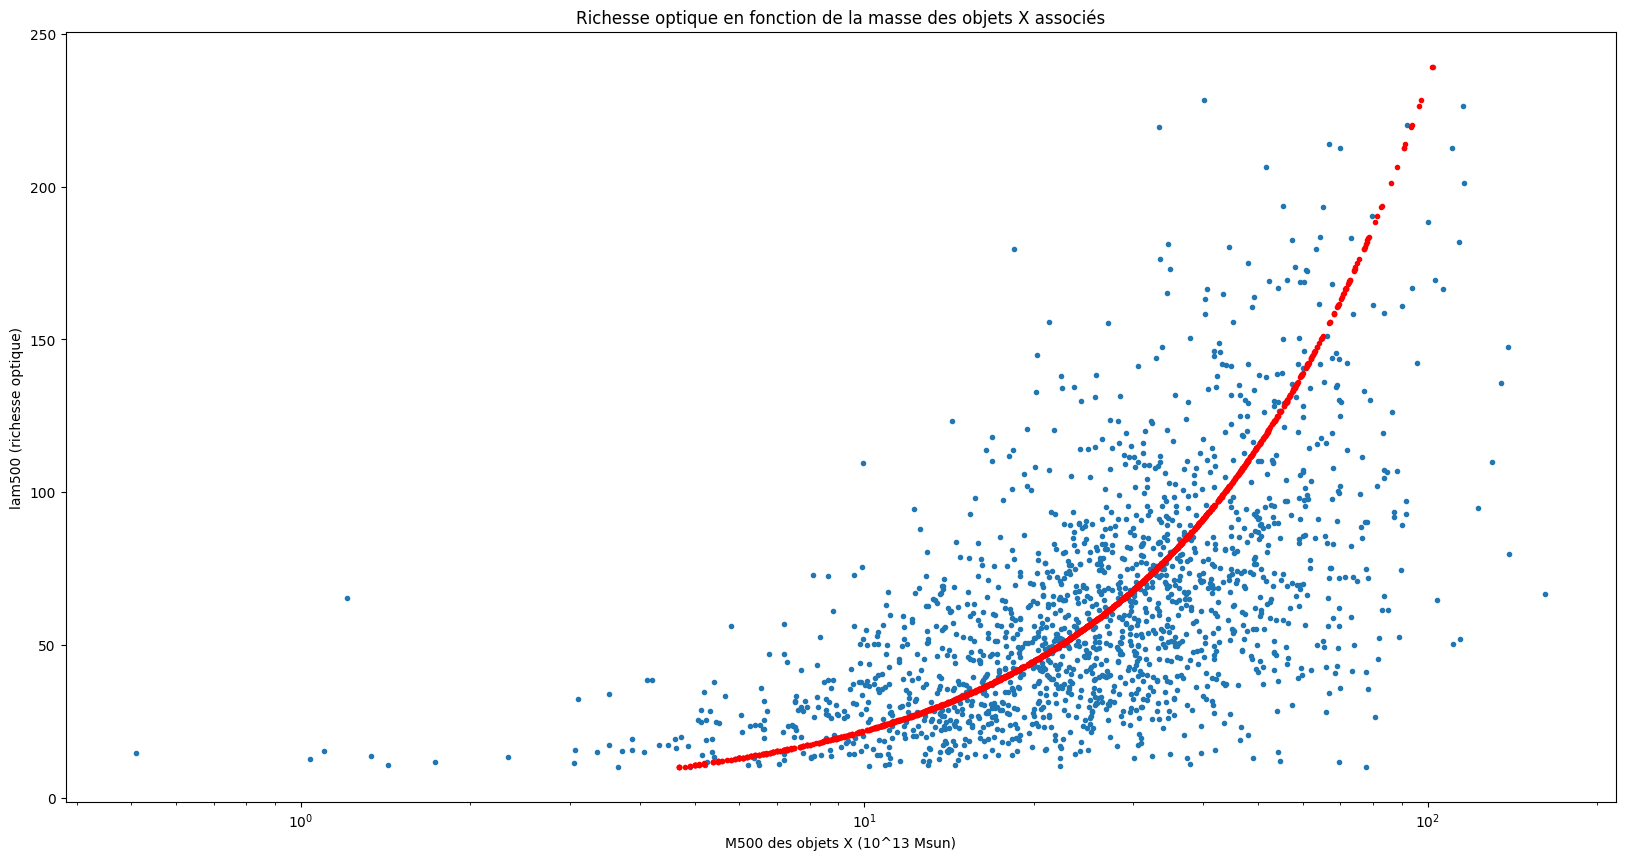

In [97]:
# grahe richess optique - M500

plt.figure(figsize=(20, 10))
plt.plot(M500_X,richness, 'o', markersize=3)
plt.plot(M_500_opt,richness, 'o',color = 'red', markersize=3)
plt.xlabel('M500 des objets X (10^13 Msun)')
plt.ylabel('lam500 (richesse optique)')
plt.title('Richesse optique en fonction de la masse des objets X associés')
plt.xscale('log')

Text(0.5, 1.0, 'Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun)')

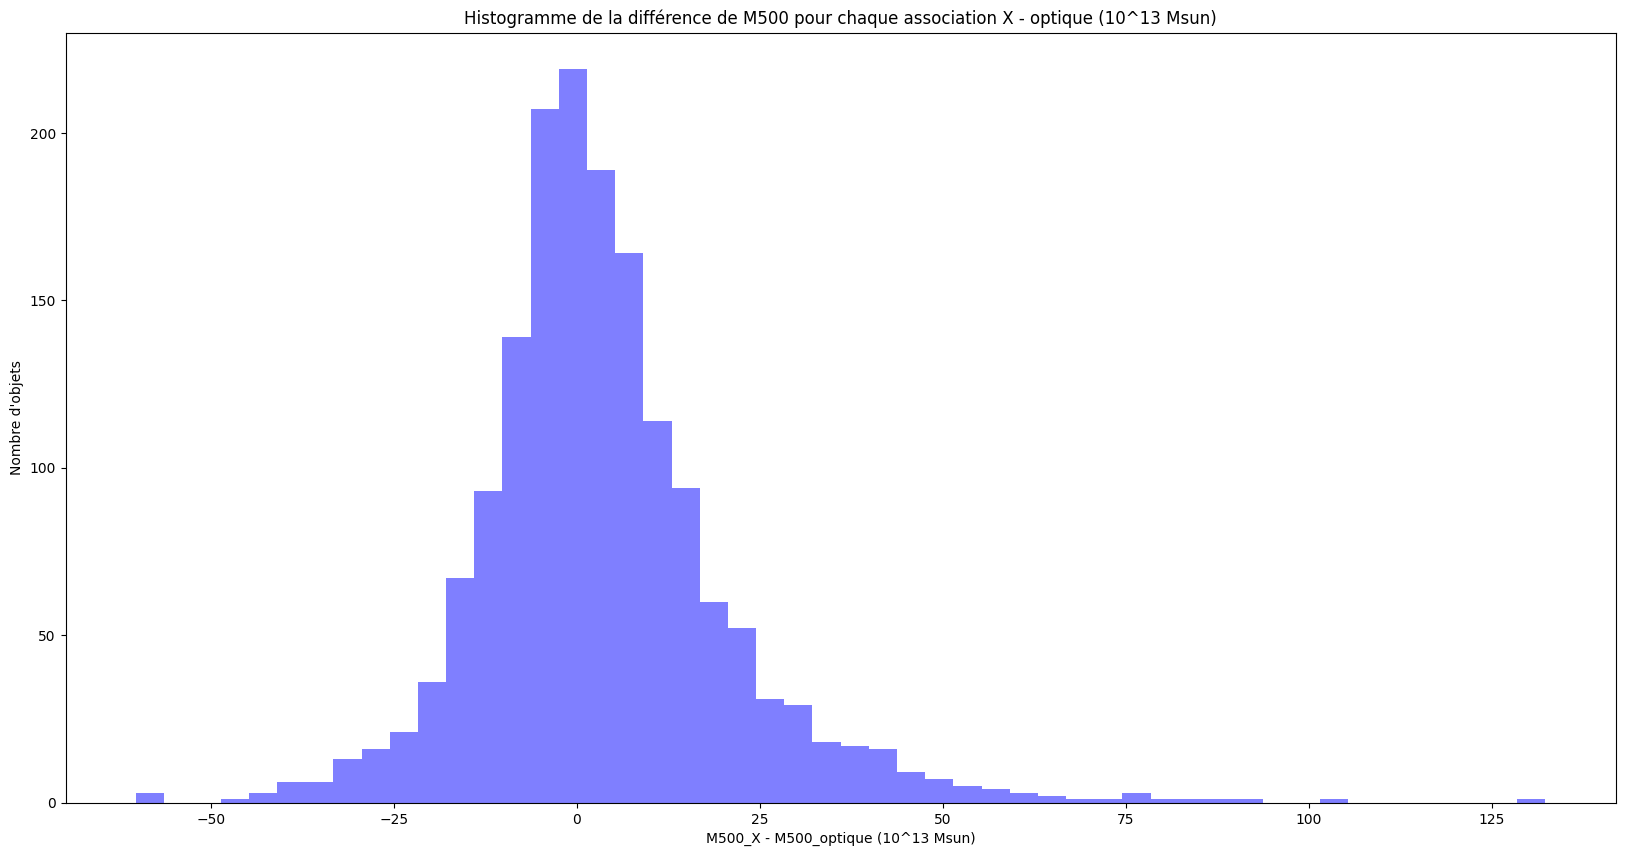

In [73]:
# Histogramme M500_X - M500_optique
diff_mass = M500_X - M_500_opt

plt.figure(figsize=(20, 10))
plt.hist(diff_mass, bins=50, color='blue', alpha=0.5)
plt.xlabel('M500_X - M500_optique (10^13 Msun)')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun)')

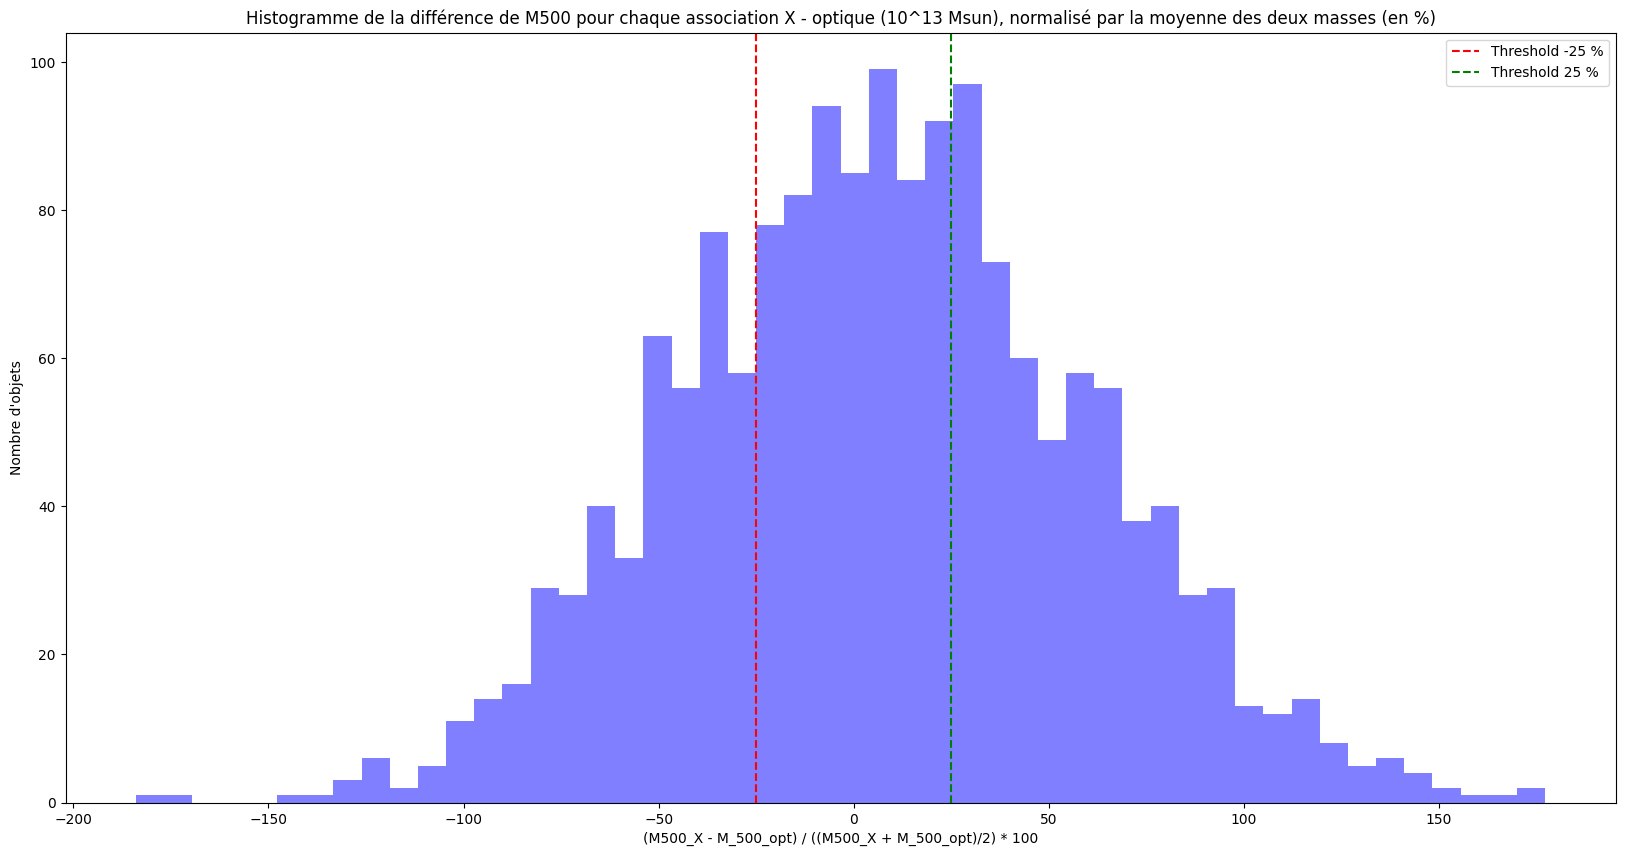

In [72]:
diff_mass_normalisée = ((M500_X - M_500_opt) / ((M500_X + M_500_opt)/2))*100


plt.figure(figsize=(20, 10))
plt.hist(diff_mass_normalisée , bins=50, color='blue', alpha=0.5)

# Add thresholds
threshold1 = -25  # Example threshold
threshold2 = 25   # Example threshold
plt.axvline(x=threshold1, color='red', linestyle='--', label=f'Threshold {threshold1} %')
plt.axvline(x=threshold2, color='green', linestyle='--', label=f'Threshold {threshold2} %')

plt.xlabel('(M500_X - M_500_opt) / ((M500_X + M_500_opt)/2) * 100')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun), normalisé par la moyenne des deux masses (en %)')

plt.legend()

In [ ]:
# on récupère les indices des associations dont la différence de masse normalisée est supérieure à 25% (en valeur absolue)
suspect_associations_mass = []
for i in range(len(diff_mass_normalisée)):
    if abs(diff_mass_normalisée[i]) > 25:
        suspect_associations_mass.append(i)

suspect_associations_mass_indexes = np.zeros((len(suspect_associations_mass), 2))  # Initialize a 2D array with zeros
i = 0
for x in suspect_associations_mass:
    suspect_associations_mass_indexes[i][0] = table_X_crossed_3D_selected.iloc[x].name
    suspect_associations_mass_indexes[i][1] = table_optique_associated_3D_selected.iloc[x].name
    i += 1
suspect_associations_mass_indexes
suspect_associations_mass_indexes_X = suspect_associations_mass_indexes[:,0].astype(int)
suspect_associations_mass_indexes_opt = suspect_associations_mass_indexes[:,1].astype(int)

print("Proportion d'associations suspectes en termes de diffrences de masse par rapport au nombre total d'associations : ", round(len(suspect_associations_mass)/len(diff_mass_normalisée)*100,3), "%")

Proportion d'associations suspectes en termes de diffrences de masse par rapport au nombre total d'associations :  59.818 %


In [124]:
suspect_associations_mass_indexes
table_X_crossed_3D_selected_suspect = table_X_crossed_3D_selected.loc[suspect_associations_mass_indexes_X] # On récupère les objets X des associations suspectes
table_optique_associated_3D_selected_suspect = table_optique_associated_3D_selected.loc[suspect_associations_mass_indexes_opt] # On récupère les objets optiques des associations suspectes

In [125]:
table_X_crossed_3D_selected_suspect

,__indexes,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,zType,...,L500,KT,Mgas500,YX500,M500,Fgas500,R500,id_asso,diff_z,dist_ang
6612,6612,110.078268,23.816921,1eRASS J072018.7+234900,110.078268,23.816921,71.099998,0.1650,0.0014,spec_z_boot,...,148.820,4.14,286.679993,1321.12,47.380001,0.060,1123,1112434,0.0046,0.001077
6660,6660,111.618954,27.170115,1eRASS J072628.5+271012,111.618954,27.170115,76.500000,0.5739,0.0070,photo_z,...,499.358,0.67,556.960022,372.14,44.549999,0.122,942,1115033,0.0071,0.006459
6677,6677,111.954727,22.753730,1eRASS J072749.1+224513,111.954727,22.753730,77.599998,0.4557,0.0095,photo_z,...,136.602,NaN,188.970001,0.00,23.770000,0.071,801,1115600,0.0021,0.000244
6683,6683,112.128600,26.709046,1eRASS J072830.8+264232,112.128600,26.709046,73.800003,0.1440,0.0006,spec_z_boot,...,20.335,NaN,27.120001,0.00,10.780000,0.027,691,1115895,0.0012,0.002665
6690,6690,112.262557,33.014368,1eRASS J072903.0+330051,112.262557,33.014368,76.800003,0.1477,0.0017,spec_z_boot,...,66.633,NaN,181.710007,0.00,27.600000,0.065,944,1116138,0.0015,0.000691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,11122,232.614267,-12.950820,1eRASS J153027.4-125702,232.614267,-12.950820,222.800003,0.5063,0.0090,photo_z,...,198.249,NaN,86.040001,0.00,31.760000,0.030,865,768599,0.0158,0.004377
11140,11140,234.344081,-16.596097,1eRASS J153722.5-163545,234.344081,-16.596097,105.199997,0.0241,0.0000,lit_z,...,12.580,NaN,63.040001,0.00,11.080000,0.055,725,771428,0.0001,0.000774
11142,11142,234.486504,-6.022300,1eRASS J153756.7-060120,234.486504,-6.022300,239.500000,0.5083,0.0083,photo_z,...,189.228,1.61,324.089996,606.51,32.320000,0.099,869,771639,0.0045,0.003578
11145,11145,234.619903,-28.929993,1eRASS J153828.7-285547,234.619903,-28.929993,105.300003,0.1980,0.0056,photo_z,...,32.626,NaN,21.670000,0.00,12.480000,0.020,712,771857,0.0139,0.002434


In [126]:
table_optique_associated_3D_selected_suspect

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
1112434,110.07758,23.81775,1112435,,J072018.6+234904,110.07758,23.81775,0.1696,0,14.859,...,12.00,0.952,60.15,26.7,38,0.14,0.05,2,WHY18,1112435
1115033,111.62539,27.17066,1115034,,J072630.1+271014,111.62539,27.17066,0.5810,0,18.022,...,11.87,0.765,51.64,23.0,22,0.00,0.00,2,AMF,1115034
1115600,111.95452,22.75386,1115601,,J072749.1+224514,111.95452,22.75386,0.4578,0,18.756,...,11.18,0.630,26.43,12.0,22,0.00,0.00,2,CFSFDP,1115601
1115895,112.12689,26.71109,1115896,,J072830.5+264240,112.12689,26.71109,0.1452,1,15.310,...,11.63,0.936,56.62,25.1,43,-1.02,0.12,2,WHL,1115896
1116138,112.26267,33.01505,1116139,,J072903.0+330054,112.26267,33.01505,0.1492,1,15.492,...,11.61,0.807,34.86,15.7,28,0.00,0.00,2,redMaPPer,1116139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768599,232.61003,-12.95192,768600,,J153026.4-125707,232.61003,-12.95192,0.5221,0,18.406,...,11.59,0.669,32.04,14.5,22,0.00,0.00,1,WHL,768600
771428,234.34340,-16.59573,771429,WH-,J153722.4-163545,234.34340,-16.59573,0.0240,1,11.275,...,11.47,0.615,10.94,5.1,6,0.00,0.00,1,,771429
771639,234.49002,-6.02164,771640,WH-,J153757.6-060118,234.49002,-6.02164,0.5128,0,17.140,...,12.20,0.988,123.34,53.5,53,0.02,0.06,1,,771640
771857,234.62193,-28.93134,771858,WH-,J153829.3-285553,234.62193,-28.93134,0.2119,0,15.549,...,11.90,0.799,39.06,17.5,24,0.00,0.00,1,,771858
